In [1]:
import pysam
from pysam import VariantFile
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

from tqdm import tqdm

# Loading the vcf file

In [2]:
vcf_in = VariantFile("data/eqtl_anal/ALL.wgs.mergedSV.v8.20130502.svs.genotypes.vcf")  # auto-detect input format

### investigation of header

In [3]:
print(vcf_in.header)

##fileformat=VCFv4.1
##FILTER=<ID=PASS,Description="All filters passed">
##reference=ftp://ftp.1000genomes.ebi.ac.uk//vol1/ftp/technical/reference/phase2_reference_assembly_sequence/hs37d5.fa.gz
##INFO=<ID=TSD,Number=1,Type=String,Description="Precise Target Site Duplication for bases, if unknown, value will be NULL">
##INFO=<ID=SVTYPE,Number=1,Type=String,Description="Type of structural variant">
##INFO=<ID=MSTART,Number=1,Type=Integer,Description="Mitochondrial start coordinate of inserted sequence">
##INFO=<ID=MLEN,Number=1,Type=Integer,Description="Estimated length of mitochondrial insert">
##INFO=<ID=MEND,Number=1,Type=Integer,Description="Mitochondrial end coordinate of inserted sequence">
##INFO=<ID=MEINFO,Number=4,Type=String,Description="Mobile element info of the form NAME,START,END<POLARITY; If there is only 5' OR 3' support for this call, will be NULL NULL for START and END">
##INFO=<ID=SVLEN,Number=.,Type=Integer,Description="Difference in length between REF and ALT allele

# Loading file with gene expressions

In [4]:
gene_express = pd.read_csv("data/eqtl_anal/GD462.GeneQuantRPKM.50FN.samplename.resk10.txt", sep='\t')  # auto-detect input format

# Loading file with vcf file as dataframe

In [5]:
n_skip=0
with open("data/eqtl_anal/ALL.wgs.mergedSV.v8.20130502.svs.genotypes.vcf", 'r') as f:
    for line in f:
        if line[:2] == '##':
            n_skip+=1
        else:
            break

In [6]:
vcf_csv = pd.read_csv("data/eqtl_anal/ALL.wgs.mergedSV.v8.20130502.svs.genotypes.vcf", skiprows=n_skip, sep='\t') 

/home/marek/anaconda3/envs/bioinf/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### verifying the size of the file

In [7]:
vcf_csv.shape

(68818, 2513)

In [8]:
vcf_csv['ID'].unique().shape

(68818,)

# Investigation of data

In [9]:
gene_express.head()

,TargetID,Gene_Symbol,Chr,Coord,HG00096,HG00097,HG00099,HG00100,HG00101,HG00102,...,NA20810,NA20811,NA20812,NA20813,NA20814,NA20815,NA20816,NA20819,NA20826,NA20828
0,ENSG00000152931.6,ENSG00000152931.6,5,59783540,0.101858,0.078110,0.048981,0.118597,0.004035,0.010925,...,0.088601,0.240010,0.137175,0.148494,0.038643,0.088509,0.029204,0.024423,0.044816,0.139186
1,ENSG00000183696.9,ENSG00000183696.9,7,48128225,8.183805,5.686911,2.434653,3.830894,6.612288,4.709646,...,13.428205,6.094500,12.536000,2.217262,3.573394,7.583364,4.052882,1.570378,4.900372,6.737308
2,ENSG00000139269.2,ENSG00000139269.2,12,57846106,1.199910,1.573572,0.521616,1.447225,3.565791,1.982681,...,3.225880,1.996067,2.854923,2.267343,1.331201,2.187895,1.004250,3.003316,1.984362,1.684954
3,ENSG00000169129.8,ENSG00000169129.8,10,116164515,0.831940,0.069778,0.931086,0.620941,1.660668,0.570481,...,1.023381,1.127852,0.774409,1.495854,0.895342,1.513521,0.826377,1.021201,0.952502,0.740565
4,ENSG00000134602.11,ENSG00000134602.11,X,131157293,27.646422,24.395572,16.445374,24.806650,25.113349,19.233988,...,25.079490,28.725528,24.450520,27.264069,26.912814,29.509210,26.462331,25.624009,25.707741,22.824957


In [10]:
vcf_csv.head()

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,HG00096,...,NA21128,NA21129,NA21130,NA21133,NA21135,NA21137,NA21141,NA21142,NA21143,NA21144
0,1,645710,ALU_umary_ALU_2,A,<INS:ME:ALU>,.,.,AC=35;AF=0.00698882;AFR_AF=0;AMR_AF=0.0072;AN=...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
1,1,668630,DUP_delly_DUP20532,G,<CN2>,.,PASS,AC=64;AF=0.0127795;AFR_AF=0.0015;AMR_AF=0;AN=5...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
2,1,713044,DUP_gs_CNV_1_713044_755966,C,"<CN0>,<CN2>",.,PASS,"AC=3,206;AF=0.00059904,0.0411342;AFR_AF=0,0.03...",GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,2|0,0|0,2|0,0|2
3,1,738570,UW_VH_21763,G,<CN0>,100,PASS,AC=1;AF=0.00019968;AFR_AF=0;AMR_AF=0;AN=5008;C...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
4,1,766600,UW_VH_5595,G,<CN0>,100,PASS,AC=188;AF=0.0375399;AFR_AF=0.0151;AMR_AF=0.062...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0


## Using only overlapping columns

In [11]:
# vcf_csv.columns[9:]
# gene_express.columns[4:]
both_cols = list(set(gene_express.columns[4:].values).intersection( set(vcf_csv.columns[9:].values) ))

In [12]:
# iterate over genes and check mutations near to it

## Performing the analysis

In [17]:
if True:
    df_eqtl = pd.read_csv('eQTL_results.csv')
    
else:
    eqtl_list =[]
    for i, gene in tqdm(gene_express[ both_cols + ['Chr', 'Coord', 'Gene_Symbol']].iterrows(), 
                        total=gene_express.shape[0], position=0, leave=True):
        #+/-1Mb
        c = gene['Coord']
        ch = gene['Chr']
        g = gene['Gene_Symbol']

        for j, mutation in vcf_csv[ both_cols + ['ID']][
            (vcf_csv['POS']>c-10**6)
            &(vcf_csv['POS']<c+10**6)
            &(vcf_csv['#CHROM']==ch)].iterrows():


            df = pd.merge(mutation[both_cols], gene[both_cols], left_index=True, right_index=True)
            df.columns = ['sv', 'expression']        
            df = df[df['sv'].str.strip() != '.']
            df['expression'] = df['expression'].astype(float)

            grouped = df.groupby('sv').mean().sort_values('expression')

    #         ax = sns.boxplot(x="sv", y="expression", 
    #                          data=df,
    #                          order=grouped.index)
    #         plt.title(f'gene {g}, sv {mutation["ID"]}')
    #         plt.show()


            df['sv_num'] = 0

            for mut_i, mut in enumerate(grouped.index):
                df.loc[df['sv'] == mut, 'sv_num'] = mut_i

            model = sm.OLS.from_formula("expression ~ sv_num", data=df)
            result = model.fit()
    #         print(f' p-values: {result.pvalues["sv_num"]:0.3f}')

            eqtl_list.append([g, mutation["ID"],result.f_pvalue])
        
    df_eqtl = pd.DataFrame(eqtl_list, columns =['gene', 'sv', 'pvalue'])
    
    df_eqtl.to_csv('eQTL_results.csv', index=False)

### Printing results with pvalue < 0.001

In [18]:
df_eqtl[df_eqtl['pvalue'] < 0.001]

,gene,sv,pvalue
62,ENSG00000242284.2,UW_VH_4107,6.047233e-04
160,ENSG00000075240.12,ALU_umary_ALU_12528,1.020899e-04
224,ENSG00000129680.11,DUP_gs.X_CNV_X_134810690_134828847,8.311515e-04
225,ENSG00000129680.11,DEL_pindel_54644,6.566471e-04
226,ENSG00000129680.11,DUP_gs.X_CNV_X_134815179_134851699,8.884108e-04
...,...,...,...
31621,ENSG00000224975.1,DUP_gs.X_CNV_X_47862951_48003688,8.269781e-11
31622,ENSG00000224975.1,DUP_gs.X_CNV_X_47999721_48056440,6.923358e-10
31623,ENSG00000224975.1,DUP_gs.X_CNV_X_48047631_48086232,9.737744e-11
31624,ENSG00000224975.1,DEL_pindel_53651,1.221926e-09


# Visualisations

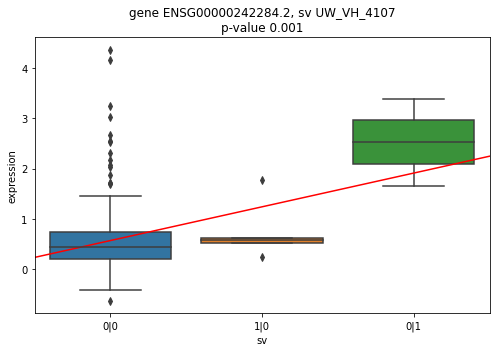

In [19]:
gene = gene_express[gene_express['Gene_Symbol'] == 'ENSG00000242284.2'][ both_cols + ['Chr', 'Coord', 'Gene_Symbol']]
#+/-1Mb
c = gene['Coord'].values[0]
ch = gene['Chr'].values[0]
g = gene['Gene_Symbol'].values[0]


mutation = vcf_csv[(vcf_csv['ID']=='UW_VH_4107')
                    &(vcf_csv['POS']>c-10**6)
                    &(vcf_csv['POS']<c+10**6)
                    &(vcf_csv['#CHROM']==ch)][ both_cols + ['ID']]


df = pd.merge(mutation[both_cols].T, gene[both_cols].T, left_index=True, right_index=True)
df.columns = ['sv', 'expression']     
df = df[df['sv'].str.strip() != '.']
df['expression'] = df['expression'].astype(float)

grouped = df.groupby('sv').mean().sort_values('expression')

df['sv_num'] = 0

for mut_i, mut in enumerate(grouped.index):
    df.loc[df['sv'] == mut, 'sv_num'] = mut_i

model = sm.OLS.from_formula("expression ~ sv_num", data=df)
result = model.fit()

b, a = result.params['Intercept'],  result.params['sv_num']

plt.figure(figsize=(7,5))

ax = sns.boxplot(x="sv", y="expression", 
                 data=df,
                 order=grouped.index)
plt.plot([-0.5, (mut_i+0.5)], [-0.5*a + b, (mut_i+0.5)*a+b], 'r')
plt.title(f'gene {g}, sv {mutation["ID"].values[0]}\np-value {result.f_pvalue:0.3f}')
plt.tight_layout()
plt.savefig('bixplot_01.png', bbox_inches='tight')

In [23]:
genes_influenced = df_eqtl[(df_eqtl['sv'] == 'UW_VH_4107')&(df_eqtl['pvalue'] < 0.05 )]['gene'].values.tolist()

In [30]:
genes_pos = gene_express[gene_express['Gene_Symbol'].isin(genes_influenced)]['Coord'].values

In [31]:
sv_pos = vcf_csv[vcf_csv['ID']=='UW_VH_4107']['POS'].values

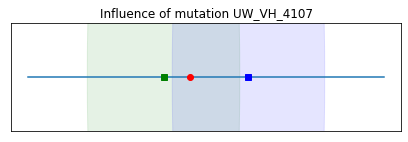

In [54]:
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(figsize=(7,2))

ax.plot( [ np.min(genes_pos)-11**6 , np.max(genes_pos)+11**6 ] , [0, 0] )

ellipse = Ellipse((np.min(genes_pos), 0), 2*10**6, 1, alpha=0.1, color='g')
ax.add_artist(ellipse)

ellipse = Ellipse((np.max(genes_pos), 0), 2*10**6, 1, alpha=0.1, color='b')
ax.add_artist(ellipse)

plt.plot( genes_pos[0] , [0], 'gs' )
plt.plot( genes_pos[1] , [0], 'bs' )

plt.xticks([])
plt.yticks([])

plt.plot( sv_pos , [0], 'ro' )

plt.title('Influence of mutation UW_VH_4107')

plt.savefig('influence.png', bbox_inches='tight')